
2. **Прогноз диабета по клинико-демографическим данным**
   - Предобработка табличных признаков (One-Hot, стандартизация, SMOTE).
   - Построение двунаправленных LSTM/GRU для мультиклассовой классификации (нет диабета, преддиабет, диабет).
   - Эксперименты по подбору числа временных единиц, dropout, размера batch, оценки на отложенной выборке.



In [ ]:
!pip install sentencepiece

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential, layers, optimizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score


ЗАДАЧА №2 Прогноз диабета, с kaggle https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset

In [ ]:
import pandas as pd


df_dataset = pd.read_csv('/content/drive/MyDrive/Text_MLmedicine/diabets2/diabetes_012_health_indicators_BRFSS2015.csv')

df_dataset

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0.0,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,5.0,0.0,1.0,5.0,6.0,7.0
253676,2.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0
253677,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,2.0
253678,0.0,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,7.0,5.0,1.0


In [ ]:
df_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [ ]:
features = ["HighChol", "Fruits", "HighBP", "CholCheck", "BMI", "Age", "Education"]

target = "Diabetes_012"

In [ ]:
# — бинарные категориальные: HighChol, Fruits, HighBP, CholCheck
# — Education: порядковая категориальная (1…6)
# — BMI, Age: числовые непрерывные

binary_cols = ["HighChol", "Fruits", "HighBP", "CholCheck"]
ordinal_cols = ["Education"]
numeric_cols = ["BMI", "Age"]

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer([
    # бинарные — оставляем как есть (0/1)
    ("bin",      "passthrough", binary_cols),
    # порядковые — one-hot
    ("order",    OneHotEncoder(categories='auto', drop='first', sparse_output=False), ordinal_cols),
    # численные — стандартизация
    ("num",      StandardScaler(), numeric_cols),
], remainder="drop")

pipeline = Pipeline([
    ("preproc", preprocessor),
])

pipeline

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('bin', 'passthrough',
                                                  ['HighChol', 'Fruits',
                                                   'HighBP', 'CholCheck']),
                                                 ('order',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['Education']),
                                                 ('num', StandardScaler(),
                                                  ['BMI', 'Age'])]))])

In [ ]:
X_proc = pipeline.fit_transform(X)

In [ ]:
# Augmentation
from imblearn.over_sampling import SMOTE


smote = SMOTE(random_state=87564555)
X_bal, y_bal = smote.fit_resample(X_proc, y)

X_bal, y_bal

(array([[ 1.        ,  0.        ,  1.        , ...,  0.        ,
          1.75793567,  0.31690008],
        [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         -0.51180614, -0.33793279],
        [ 1.        ,  1.        ,  1.        , ...,  0.        ,
         -0.05785778,  0.31690008],
        ...,
        [ 0.        ,  1.        ,  1.        , ...,  0.        ,
          0.85003895,  0.97173295],
        [ 1.        ,  1.        ,  1.        , ...,  0.        ,
         -0.05785778,  0.31690008],
        [ 1.        ,  1.        ,  1.        , ...,  0.        ,
          0.69872283,  0.64431652]]),
 0         0.0
 1         0.0
 2         0.0
 3         0.0
 4         0.0
          ... 
 641104    2.0
 641105    2.0
 641106    2.0
 641107    2.0
 641108    2.0
 Name: Diabetes_012, Length: 641109, dtype: float64)

In [ ]:
print(f"Было: {len(X_proc)} \nСтало:{len(X_bal)}")
X_bal.shape[1]

Было: 253680 
Стало:641109


11

In [ ]:
import numpy as np

X_rnn = X_bal.reshape((-1, 1, X_bal.shape[1]))
y_rnn = y_bal

X_rnn.shape, np.bincount(y_rnn)

((641109, 1, 11), array([213703, 213703, 213703]))

In [ ]:
# Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_rnn, y_rnn,
    test_size=0.2,
    random_state=58874,
    stratify=y_rnn
)

In [ ]:
y_train = y_train.squeeze()
y_test  = y_test.squeeze()

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

(512887, 128222, 512887, 128222)

In [ ]:
import numpy as np

print("Форма входа для RNN:", X_train.shape, X_test.shape)
print("Форма выхода для RNN:", y_train.shape, y_test.shape)
print("Распределение классов в y_train:", np.bincount(y_train))
print("Распределение классов в y_test:",  np.bincount(y_test))

Форма входа для RNN: (512887, 1, 11) (128222, 1, 11)
Форма выхода для RNN: (512887,) (128222,)
Распределение классов в y_train: [170963 170962 170962]
Распределение классов в y_test: [42740 42741 42741]


In [ ]:
# построения модели
from tensorflow.keras import Model, Input, layers, optimizers, callbacks

def build_rnn_classifier(model_type: str,
                         units_bi: int=32,
                         units: int=32,
                         dropout: float=0.3,
                         recurrent_dropout: float=0.3):
    inp = Input(shape=(1, 11), name="in")
    if model_type == "LSTM":
        rnn_layer = layers.LSTM(units_bi, return_sequences=True,
                                recurrent_dropout=recurrent_dropout)
    else:
        rnn_layer = layers.GRU(units_bi, return_sequences=True,
                               recurrent_dropout=recurrent_dropout)
    x = layers.Bidirectional(rnn_layer)(inp)
    x = layers.Dropout(dropout)(x)
    if model_type == "LSTM":
        x = layers.LSTM(units, recurrent_dropout=recurrent_dropout)(x)
    else:
        x = layers.GRU(units, recurrent_dropout=recurrent_dropout)(x)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(3, activation="softmax")(x)
    model = Model(inp, out)
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=optimizers.Adam(1e-3),
        metrics=["accuracy"]
    )
    return model

In [ ]:
results = []
# NAME, bid_units, units, dropout, batch_size
batch_size = 64
dropout = 0.1

param_grid = [
    ("LSTM", 128, 128, 0.3, 32),

    ("GRU", 128, 128, 0.3, 32),
]
for model_type, u_bi, u, do, bs in param_grid:
    model = build_rnn_classifier(
        model_type,
        units_bi=u_bi,
        units=u,
        dropout=do,
        recurrent_dropout=do
        )
    print(f"Training {model_type} bid_units: {u_bi}, units: {u}")
    hist = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=10,
        batch_size=bs,
        callbacks=[
            callbacks.EarlyStopping(
                monitor="val_loss",
                patience=2,
                restore_best_weights=True
                )
            ]
    )
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    results.append({
        "Model": model_type,
        "Bi-units": u_bi,
        "Units": u,
        "Epochs": len(hist.history["loss"]),
        "Batch": bs,
        "Val Acc": round(max(hist.history["val_accuracy"]),4),
        "Test Acc": round(acc,4),
        "Test Loss": round(loss,4)
    })

table = pd.DataFrame(results)
print(table)


Training LSTM bid_units: 128, units: 128
Epoch 1/10
1603/1603 ━━━━━━━━━━━━━━━━━━━━ 85s 47ms/step - accuracy: 0.4909 - loss: 0.9882 - val_accuracy: 0.4967 - val_loss: 0.9785
Epoch 2/10
1603/1603 ━━━━━━━━━━━━━━━━━━━━ 70s 44ms/step - accuracy: 0.4969 - loss: 0.9768 - val_accuracy: 0.4963 - val_loss: 0.9775
Epoch 3/10
1603/1603 ━━━━━━━━━━━━━━━━━━━━ 82s 44ms/step - accuracy: 0.5023 - loss: 0.9740 - val_accuracy: 0.4976 - val_loss: 0.9759
Epoch 4/10
1603/1603 ━━━━━━━━━━━━━━━━━━━━ 87s 47ms/step - accuracy: 0.5001 - loss: 0.9747 - val_accuracy: 0.4996 - val_loss: 0.9748
Epoch 5/10
1603/1603 ━━━━━━━━━━━━━━━━━━━━ 77s 44ms/step - accuracy: 0.5013 - loss: 0.9726 - val_accuracy: 0.4999 - val_loss: 0.9742
Epoch 6/10
1603/1603 ━━━━━━━━━━━━━━━━━━━━ 81s 43ms/step - accuracy: 0.5009 - loss: 0.9734 - val_accuracy: 0.5022 - val_loss: 0.9741
Epoch 7/10
1603/1603 ━━━━━━━━━━━━━━━━━━━━ 71s 44ms/step - accuracy: 0.5028 - loss: 0.9722 - val_accuracy: 0.5018 - val_loss: 0.9733
Epoch 8/10
1603/1603 ━━━━━━━━━━━━━━

In [ ]:
best = sorted(results, key=lambda x: -x["Test Acc"])[0]
print("Лучшая модель:", best)


Лучшая модель: {'Model': 'GRU', 'Bi-units': 128, 'Units': 128, 'Epochs': 10, 'Batch': 64, 'Val Acc': 0.5231, 'Test Acc': 0.5251, 'Test Loss': 0.9498}


In [ ]:
best_model = build_rnn_classifier(best["Model"], best["Bi-units"], best["Units"])
best_model.fit(X_train, y_train, epochs=best["Epochs"], batch_size=batch_size, verbose=0)

best_model

<Functional name=functional_18, built=True>

In [ ]:
y_pred = np.argmax(best_model.predict(X_test), axis=1)
y_true = y_test

y_true, y_pred

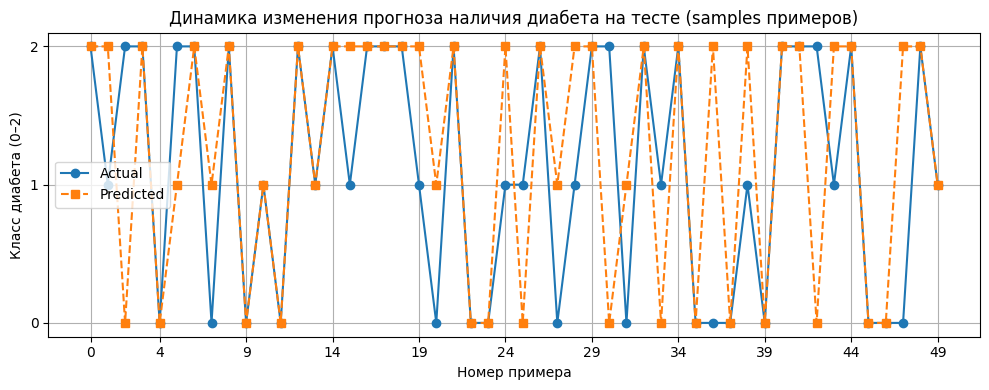

In [ ]:
import matplotlib.pyplot as plt

samples = 50
x = np.arange(samples)

plt.figure(figsize=(10,4))
plt.plot(x, y_true[:samples],   label="Actual",    marker="o")
plt.plot(x, y_pred[:samples],   label="Predicted", linestyle="--", marker="s")
plt.title("Динамика изменения прогноза наличия диабета на тесте (samples примеров)")
plt.xlabel("Номер примера")
plt.ylabel("Класс диабета (0–2)")
plt.xticks(np.linspace(0, samples-1, 11, dtype=int))
plt.yticks([0,1,2])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()